In [12]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from functools import partial
from astropy import constants as c
from pfu_transit.planet_atmosphere_extinction import ExoplanetAtmosphere
from pfu_transit.mask_generation import generate_exoplanet, generate_star
from pfu_transit.photometry_simulation import photometric_observation
from scipy.interpolate import interp1d

In [13]:
datasets = ['Qatar-6 b.txt', 'TrES-2 b.txt', 'TrES-5 b.txt', 'WASP-2 b.txt', 'WASP-52 b.txt']
data = np.genfromtxt(f"assets/exoplanet_data/{datasets[2]}", delimiter=',', names=True, skip_header=23)

interp = np.genfromtxt(f"assets/interp_data/TrES-5 b_interp.txt", delimiter=',', names=True)
interp_dates = interp['x_interp']
interp_dates_min = (interp_dates - interp_dates[0])
interp_flux = interp['y_interp']
interp_errs = interp['y_err']

dates = data['DATE']
dates_mins = (dates - dates[0]) * 24 * 60
flux = data['DIFF']
errs = data['ERR']

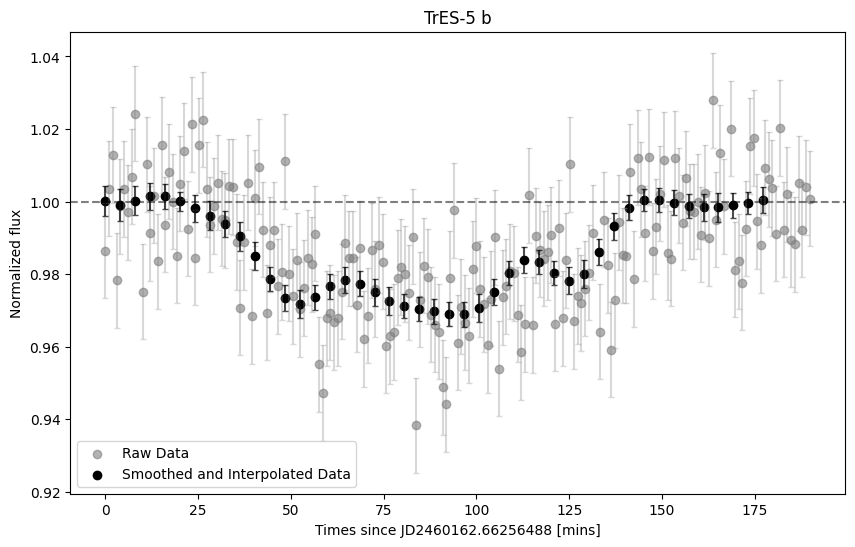

In [14]:
plt.figure(figsize=[10, 6])

plt.scatter(dates_mins, flux, label = 'Raw Data', alpha = .6, c = 'gray')
plt.errorbar(dates_mins, flux, errs, ls = '', alpha = 0.3, capsize=2, c = 'gray')

plt.scatter(interp_dates_min, interp_flux, label = 'Smoothed and Interpolated Data', c = 'k')
plt.errorbar(interp_dates_min, interp_flux, interp_errs, ls = '', alpha = 0.7, capsize=2, c = 'k')

plt.xlabel(f'Times since JD{dates[0]} [mins]')
plt.ylabel('Normalized flux')
plt.legend()
plt.title(f"{datasets[2][:-4]}")
plt.axhline(1, ls = '--', c = 'k', alpha = .5)

In [15]:
## Define coarse grid ranges, can be made more fine later at a higher computational cost
Rp_vals  = np.linspace(1.5,  2.0, 3) # planet radius
b_vals   = np.linspace(0,  .7, 3) # impact param
wl_vals  = [.6]                    # wavelength
vel_vals = np.linspace(.5, 1.5, 3) # velocity

param_grid = [(Rp, b, wl, vel) for Rp in Rp_vals for b in b_vals for wl in wl_vals for vel in vel_vals]
len(param_grid)

27

In [16]:
def evaluate_params(params, t_obs, flux_obs, noise_sigma, star, image_directory = None):
    """
    params: tuple (Rp, b, wavelength, velocity)
    Returns (mse, params)
    """

    Rp, b, wavelength, velocity = params

    try:
        # build star and planet models:

        planet = generate_exoplanet(planet_radius=Rp * (c.R_jup/c.R_sun), b=b, wavelength=wavelength, no_atmosphere=True, planet_oblateness=0, planet_rot_obliquity=0)
        t_model, flux_model = photometric_observation(star= star, planet= planet, velocity=velocity, image_scale=3/2500, step=1, image_directory=image_directory, threadcount=1)

        # normalize
        flux_model = flux_model/np.max(flux_model)

        if not np.array_equal(t_model, t_obs):
            interp = interp1d(t_model, flux_model, bounds_error=False, fill_value=np.nan)
            flux_model_interp = interp(t_obs)
            # if interpolation produces NaNs - model doesnt cover full observed time - set them to baseline (1)
            nan_mask = np.isnan(flux_model_interp)
            if np.any(nan_mask):
                flux_model_interp[nan_mask] = 1.0
            flux_model = flux_model_interp

        # compute mean squared error
        mse = np.mean((flux_obs -  flux_model)**2)
        return (mse, params)
    
    except Exception as e:
        print(f'Error evaluating {params}: {e}')
        return(np.inf, params)


        

In [ ]:
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

n_workers = min(12, len(param_grid))
star = generate_star(wavelength=wl_vals[0], stellar_oblateness=0, stellar_rot_obliquity=0, stellar_radius=0.866, stellar_temperature=5171)

results = []
with ThreadPoolExecutor(max_workers=n_workers) as exe:
    futures = [exe.submit(evaluate_params, params, interp_dates_min, interp_flux, interp_errs, star, None)
               for params in param_grid]

    with tqdm(total=len(futures), desc="Grid search", leave=True) as pbar:
        for f in as_completed(futures):
            results.append(f.result())
            pbar.update(1)

results_sorted = sorted(results, key=lambda x: x[0])
best_mse, best_params = results_sorted[0]
print('Best MSE:', best_mse)
print('Best params:', best_params)


Calculating limb darkening coefficients....


100%|██████████| 1439/1439 [00:00<00:00, 3568.46it/s]


Creating mask...


100%|██████████| 1439/1439 [00:07<00:00, 200.58it/s]


Grid search:   0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
best_Rp, best_b, best_wl, best_vel = best_params
star_best = star
planet_best = generate_exoplanet(planet_radius=best_Rp * (c.R_jup/c.R_sun), b=best_b, wavelength=best_wl, planet_oblateness=0, planet_rot_obliquity=0, no_atmosphere=True)
t_best, flux_best = photometric_observation(star_best, planet_best, velocity=best_vel, threadcount=1, image_directory=None)
flux_best = flux_best/np.max(flux_best)

100%|██████████| 2201/2201 [00:41<00:00, 52.82it/s]


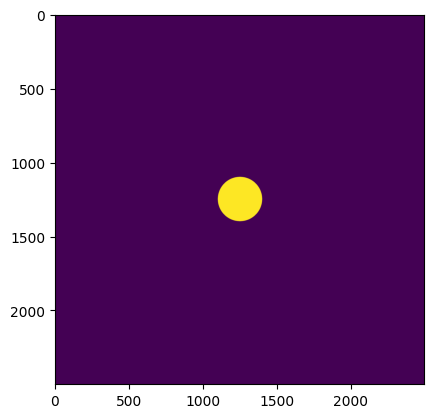

In [ ]:
plt.imshow(planet_best)
plt.show()
plt.imshow(star_best)
plt.show()

In [8]:
interp = interp1d(t_best, flux_best, bounds_error = False, fill_value = 1.0)
flux_best_i = interp(interp_dates_min)

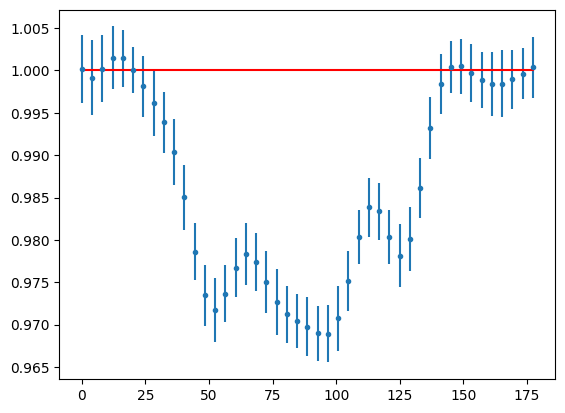

In [9]:
plt.errorbar(interp_dates_min, interp_flux, yerr=interp_errs, fmt='.')
plt.plot(interp_dates_min, flux_best_i, 'r-')